# 청년 사회적 고립 모델링

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data=pd.read_csv('final_df.csv',encoding='cp949')
data.head()

,id,q1_1,q1_2,q1_3,q1_4,q1_5,q3,q4,d1,d4,...,q33,q34_1,q34_2,q34_3,q52,q53,q54,q55,d12_1,d16
0,3,8,8,9,8,8,9,9,1,1,...,3,3,3,4,3,3,8,8,0,1
1,4,8,9,7,8,7,8,6,1,1,...,3,3,3,4,2,2,3,3,0,1
2,18,8,8,7,7,7,7,6,1,1,...,3,4,4,3,2,2,6,6,300,1
3,36,8,9,8,8,7,7,8,2,1,...,3,3,3,3,3,3,7,8,0,1
4,43,7,8,8,9,8,8,9,2,1,...,3,3,3,4,3,3,7,8,0,1


## 목적변수 Y

In [ ]:
y=pd.read_csv('social_iso.csv',encoding='cp949')

In [ ]:
y.head()

,Unnamed: 0,id,social_iso
0,0,3,16
1,1,4,11
2,2,18,17
3,3,36,12
4,4,43,14


In [ ]:
list(y[['id']])==list(data[['id']])

True

In [ ]:
data['social_iso']=y['social_iso']

(array([  4.,  38.,  49., 231., 143., 432., 251.,  83.,  45.,   1.]),
 array([ 9. , 10.6, 12.2, 13.8, 15.4, 17. , 18.6, 20.2, 21.8, 23.4, 25. ]),
 <a list of 10 Patch objects>)

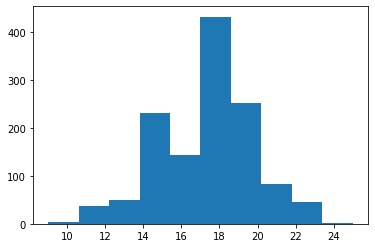

In [ ]:
plt.hist(data['social_iso'])

### (1) minmax Scaler


In [ ]:
print(data['social_iso'].min())
print(data['social_iso'].max())

9
25


In [ ]:
mn=data['social_iso'].min()
mx=data['social_iso'].max()
data['new_y']=data['social_iso'].apply(lambda x:(x-mn)/(mx-mn))

In [ ]:
data['new_y']

0       0.4375
1       0.1250
2       0.5000
3       0.1875
4       0.3125
         ...  
1272    0.4375
1273    0.6250
1274    0.5625
1275    0.5625
1276    0.5000
Name: new_y, Length: 1277, dtype: float64

(array([  4.,  38.,  49., 231., 143., 432., 251.,  83.,  45.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

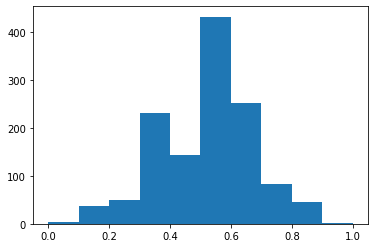

In [ ]:
plt.hist(data['new_y'])

- 분포도 변화 없음

## 회귀 모델링

### (1) lightGBM

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [ ]:
data.columns

Index(['id', 'q1_1', 'q1_2', 'q1_3', 'q1_4', 'q1_5', 'q3', 'q4', 'd1', 'd4',
       'q5_3', 'q28_1', 'q28_2', 'q28_3', 'q28_4', 'q47_2', 'q47_3', 'q47_4',
       'q47_9', 'q47_12', 'q48_1', 'q48_2', 'q48_3', 'q48_6', 'q48_7', 'q17_1',
       'q17_2', 'q17_3', 'q17_4', 'q17_5', 'q17_6', 'q17_7', 'q17_8', 'q17_9',
       'q21_1', 'q33', 'q34_1', 'q34_2', 'q34_3', 'q52', 'q53', 'q54', 'q55',
       'd12_1', 'd16', 'social_iso', 'new_y'],
      dtype='object')

In [ ]:
df=data.copy()
X=df.drop(['id','social_iso', 'new_y'],axis=1) # iso_bin
y=df['new_y']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
train_ds=lgb.Dataset(X_train,label=y_train)
test_ds=lgb.Dataset(X_test,label=y_test)

In [ ]:
params = {'learning_rate': 0.03, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2022}

In [ ]:
model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.018714
[200]	valid_0's l2: 0.0185643
Early stopping, best iteration is:
[145]	valid_0's l2: 0.0183531


In [ ]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
mse = mean_squared_error(y_test, predict_test) 
rmse = mse**(0.5)
mae=mean_absolute_error(y_test,predict_test)
print("MSE: %.4f" % mse)
print("RMSE: %.4f" % rmse) 
print("MAE: %.4f"%mae)

MSE: 0.0184
RMSE: 0.1355
MAE: 0.1049


In [ ]:
0.156795*0.5

0.0783975

In [ ]:
predict_test

array([0.42647148, 0.52815184, 0.51006127, 0.56009421, 0.60158936,
       0.54424059, 0.57697031, 0.51803414, 0.52324572, 0.56226559,
       0.48753278, 0.52333997, 0.44327477, 0.43487585, 0.39606264,
       0.46841293, 0.6190935 , 0.51101976, 0.45630607, 0.59892634,
       0.44465198, 0.4675863 , 0.52604542, 0.52278115, 0.51325128,
       0.49288118, 0.42111924, 0.51423953, 0.71389732, 0.55511809,
       0.49659233, 0.5297968 , 0.4540359 , 0.39567723, 0.519944  ,
       0.54834929, 0.49887115, 0.56327176, 0.44584764, 0.54873859,
       0.51384903, 0.57082989, 0.51176314, 0.50641239, 0.49139102,
       0.50793716, 0.47977007, 0.4822057 , 0.45586362, 0.44583743,
       0.51873293, 0.44878598, 0.53635813, 0.46509919, 0.47786914,
       0.42677605, 0.43552788, 0.45922543, 0.43459937, 0.53823585,
       0.50113294, 0.42322641, 0.54009908, 0.4992893 , 0.38620702,
       0.47761472, 0.58747176, 0.46825367, 0.46994824, 0.41479495,
       0.60184624, 0.38567426, 0.51991985, 0.63051098, 0.47579

In [ ]:
data.describe()

,id,q1_1,q1_2,q1_3,q1_4,q1_5,q3,q4,d1,d4,...,q34_2,q34_3,q52,q53,q54,q55,d12_1,d16,social_iso,new_y
count,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,...,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.00000,1277.000000,1277.000000,1277.000000,1277.000000
mean,4823.561472,6.851214,4.144088,3.566171,6.337510,6.452623,6.714957,5.703211,1.491778,1.137823,...,2.564605,2.881754,1.841817,1.841817,5.202819,6.00000,170.399374,1.513704,17.190290,0.511893
std,2552.053260,1.255000,2.193158,2.173807,1.396237,1.361237,1.395314,1.508730,0.500128,0.401548,...,0.723497,0.766227,0.747014,0.747014,1.696962,1.40141,161.354708,0.812814,2.508725,0.156795
min,3.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000,0.000000,1.000000,9.000000,0.000000
25%,2650.000000,6.000000,2.000000,2.000000,5.000000,6.000000,6.000000,5.000000,1.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,4.000000,5.00000,0.000000,1.000000,15.000000,0.375000
50%,5043.000000,7.000000,4.000000,3.000000,7.000000,7.000000,7.000000,6.000000,1.000000,1.000000,...,3.000000,3.000000,2.000000,2.000000,5.000000,6.00000,200.000000,1.000000,17.000000,0.500000
75%,7093.000000,8.000000,6.000000,5.000000,7.000000,7.000000,8.000000,7.000000,2.000000,1.000000,...,3.000000,3.000000,2.000000,2.000000,6.000000,7.00000,300.000000,2.000000,19.000000,0.625000
max,8480.000000,10.000000,10.000000,9.000000,10.000000,10.000000,10.000000,10.000000,2.000000,5.000000,...,4.000000,4.000000,4.000000,4.000000,9.000000,10.00000,800.000000,5.000000,25.000000,1.000000


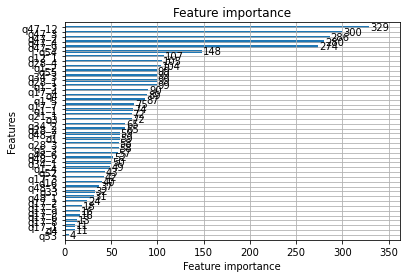

In [ ]:
lgb.plot_importance(model, height=.5)

In [ ]:
#!pip install shap

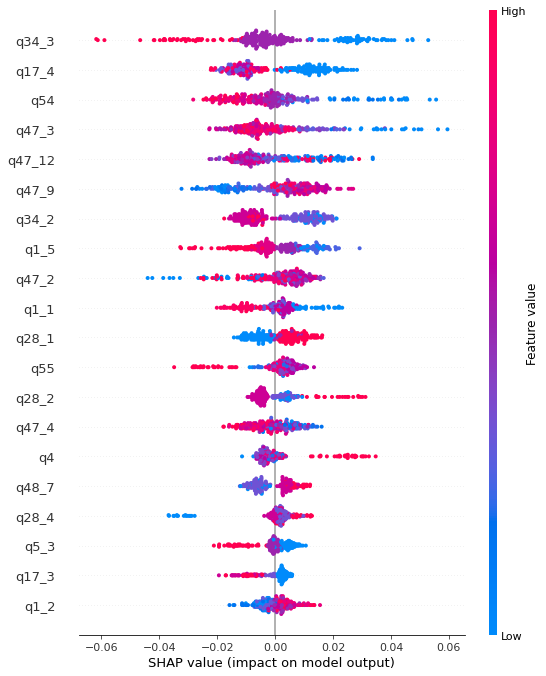

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
fig = shap.summary_plot(shap_values, X_test)
#plt.savefig(f'{PATH}/shap.png', dpi=300, bbox_inches="tight")

### (2) XGBoost

In [ ]:
import xgboost

In [ ]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.03, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [ ]:
xgb_model.fit(X_train,y_train)


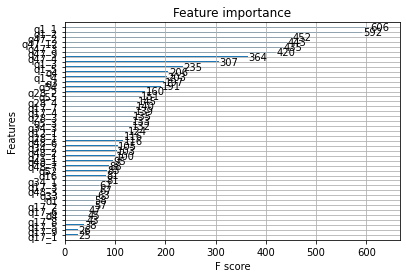

In [ ]:
xgboost.plot_importance(xgb_model)

In [ ]:
predictions = xgb_model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae=mean_absolute_error(y_test,predictions)
print("MSE: %.4f" % mse)
print("RMSE: %.4f" % rmse) 
print("MAE: %.4f"%mae)

MSE: 0.0185
RMSE: 0.1361
MAE: 0.1061


### (3) Catboost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor,CatBoostClassifier

In [ ]:
dataset.head()

,q1_1,q1_2,q1_3,q1_4,q1_5,q3,q4,d1,d4,q5_3,...,q34_1,q34_2,q34_3,q52,q53,q54,q55,d12_1,d16,new_y
0,8,8,9,8,8,9,9,1,1,3,...,3,3,4,3,3,8,8,0,1,0.4375
1,8,9,7,8,7,8,6,1,1,2,...,3,3,4,2,2,3,3,0,1,0.1250
2,8,8,7,7,7,7,6,1,1,3,...,4,4,3,2,2,6,6,300,1,0.5000
3,8,9,8,8,7,7,8,2,1,4,...,3,3,3,3,3,7,8,0,1,0.1875
4,7,8,8,9,8,8,9,2,1,2,...,3,3,4,3,3,7,8,0,1,0.3125


In [ ]:
dataset

,q1_1,q1_2,q1_3,q1_4,q1_5,q3,q4,d1,d4,q5_3,...,q34_1,q34_2,q34_3,q52,q53,q54,q55,d12_1,d16,new_y
0,8,8,9,8,8,9,9,1,1,3,...,3,3,4,3,3,8,8,0,1,0.4375
1,8,9,7,8,7,8,6,1,1,2,...,3,3,4,2,2,3,3,0,1,0.1250
2,8,8,7,7,7,7,6,1,1,3,...,4,4,3,2,2,6,6,300,1,0.5000
3,8,9,8,8,7,7,8,2,1,4,...,3,3,3,3,3,7,8,0,1,0.1875
4,7,8,8,9,8,8,9,2,1,2,...,3,3,4,3,3,7,8,0,1,0.3125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,8,1,1,6,7,7,8,2,1,4,...,3,3,2,2,2,6,6,300,5,0.4375
1273,7,2,1,6,5,5,7,2,2,3,...,4,3,3,2,2,3,5,300,2,0.6250
1274,6,2,1,6,4,3,6,1,2,4,...,4,2,3,3,3,4,6,400,2,0.5625
1275,6,3,3,6,7,5,7,1,1,3,...,4,2,3,2,2,3,6,0,3,0.5625


In [ ]:
dataset.columns[23]

'q48_7'

In [ ]:
cat_reg = CatBoostRegressor(subsample=0.55, n_estimators=900, max_depth=7, learning_rate=0.03, 
                            colsample_bylevel= 0.7)

In [ ]:
cat_reg.fit(X_train,y_train)

In [ ]:
# 맞춤형 교차검증 함수
import numpy as np
from sklearn.model_selection import cross_val_score

# Define cross_val function 
def cross_val(model,X=X,y=y, num_splits=10):
    
    # Initialize 
    model = model

    # Obtain scores of cross-validation
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=num_splits)
    rmse = np.sqrt(-scores)
    
    print('rmse:', np.round(rmse, 2))
    print('RMSE mean: %0.2f' % (rmse.mean()))

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = cat_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae=mean_absolute_error(y_test,y_pred)
print("MSE: %.4f" % mse)
print("RMSE: %.4f" % rmse) 
print("MAE: %.4f"%mae)

MSE: 0.0172
RMSE: 0.1313
MAE: 0.1010


### (4) DNN
- new data

In [ ]:
from keras.utils import np_utils
from keras import layers, models, datasets
from keras.callbacks import EarlyStopping
from tensorflow import keras
import tensorflow as tf

In [ ]:
dataset=data.drop(['social_iso','id'],axis=1) # iso_bin
dataset

,q1_1,q1_2,q1_3,q1_4,q1_5,q3,q4,d1,d4,q5_3,...,q34_1,q34_2,q34_3,q52,q53,q54,q55,d12_1,d16,new_y
0,8,8,9,8,8,9,9,1,1,3,...,3,3,4,3,3,8,8,0,1,0.4375
1,8,9,7,8,7,8,6,1,1,2,...,3,3,4,2,2,3,3,0,1,0.1250
2,8,8,7,7,7,7,6,1,1,3,...,4,4,3,2,2,6,6,300,1,0.5000
3,8,9,8,8,7,7,8,2,1,4,...,3,3,3,3,3,7,8,0,1,0.1875
4,7,8,8,9,8,8,9,2,1,2,...,3,3,4,3,3,7,8,0,1,0.3125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,8,1,1,6,7,7,8,2,1,4,...,3,3,2,2,2,6,6,300,5,0.4375
1273,7,2,1,6,5,5,7,2,2,3,...,4,3,3,2,2,3,5,300,2,0.6250
1274,6,2,1,6,4,3,6,1,2,4,...,4,2,3,3,3,4,6,400,2,0.5625
1275,6,3,3,6,7,5,7,1,1,3,...,4,2,3,2,2,3,6,0,3,0.5625


In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("new_y")
train_stats = train_stats.transpose()
#train_stats

In [ ]:
train_labels = train_dataset.pop('new_y')
test_labels = test_dataset.pop('new_y')

In [ ]:
train_labels

1271    0.5625
877     0.5625
1130    0.4375
1252    0.3750
247     0.4375
         ...  
147     0.3125
160     0.5000
1263    0.3750
750     0.6875
891     0.0000
Name: new_y, Length: 1022, dtype: float64

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2880      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,105
Trainable params: 7,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[PrintDot()])

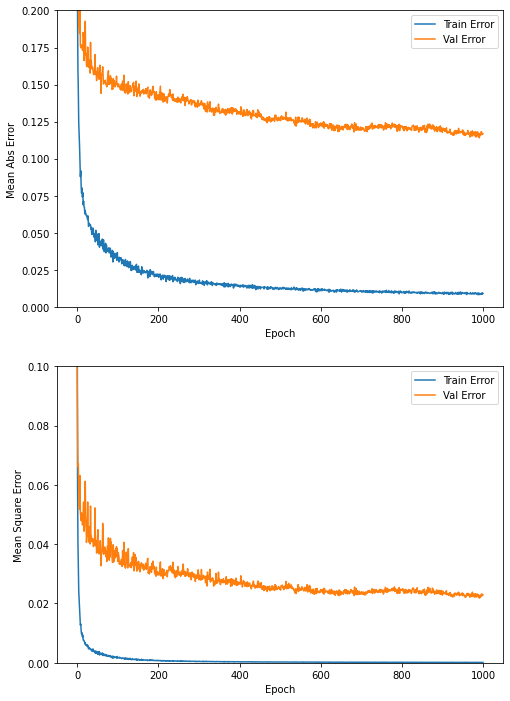

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.2])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.1])
  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
hist

,loss,mae,mse,val_loss,val_mae,val_mse
0,0.160559,0.305013,0.160559,0.099763,0.244037,0.099763
1,0.063310,0.199895,0.063310,0.081292,0.219821,0.081292
2,0.041077,0.160483,0.041077,0.066159,0.207602,0.066159
3,0.032564,0.144960,0.032564,0.067171,0.211516,0.067171
4,0.024159,0.123887,0.024159,0.058643,0.189388,0.058643
...,...,...,...,...,...,...
995,0.000126,0.008601,0.000126,0.023146,0.118334,0.023146
996,0.000149,0.009344,0.000149,0.022547,0.116413,0.022547
997,0.000126,0.008628,0.000126,0.023145,0.117286,0.023145
998,0.000148,0.009522,0.000148,0.022762,0.116627,0.022762


In [ ]:
hist[hist['val_mse']==hist['val_mse'].min()]

,loss,mae,mse,val_loss,val_mae,val_mse
990,0.000138,0.009101,0.000138,0.021827,0.114072,0.021827


In [ ]:
round(np.sqrt(0.024491),4)

0.1565

In [ ]:
round(np.sqrt(0.043026),4)

0.2074

### (5) SVR
- kernel = "rbf" : 비선형


In [ ]:
from sklearn.svm import SVR
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

In [ ]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

In [ ]:
svr_rbf.fit(X_train,y_train)
#svr_lin.fit(X_train,y_train)
#svr_poly.fit(X_train,y_train)

SVR(C=100, gamma=0.1)

In [ ]:
y_pred1=svr_rbf.predict(X_test)
#y_pred2=svr_lin.predict(X_test)
#y_pred3=svr_poly.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred1)
rmse = np.sqrt(mse)
mae=mean_absolute_error(y_test,y_pred1)
print("MSE: %.4f" % mse)
print("RMSE: %.4f" % rmse) 
print("MAE: %.4f"%mae)

MSE: 0.0217
RMSE: 0.1472
MAE: 0.1149


### (6) Linear

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [ ]:
print(lr.coef_)

[-7.47969840e-03  3.32166480e-03 -3.02617088e-03  7.94970062e-03
 -1.46957380e-02  2.10026604e-03  4.93401004e-03 -2.88645671e-03
  1.43347996e-02 -8.94123234e-03  9.83473699e-03 -4.63765975e-03
  6.63194936e-03  1.19831248e-02  2.25063628e-04 -7.28555002e-04
 -2.27860288e-04  9.60334228e-04 -2.37388270e-04  6.48147749e-03
 -5.46718094e-03  1.25431560e-02 -3.27514177e-03  1.53128794e-02
  6.12584028e-03 -1.11335884e-02 -6.93237557e-03 -1.09211897e-02
  3.96445414e-03 -4.26030791e-03  2.58655060e-03  2.23922190e-04
 -1.11725737e-03 -3.22731056e-03 -7.40484650e-03  1.61163883e-02
 -1.67597481e-02 -4.28560314e-02 -7.29314889e-03 -7.29314889e-03
 -1.08998380e-02 -3.35970870e-03 -7.52046872e-06 -1.38002551e-02]


In [ ]:
y_pred=lr.predict(X_test)

In [ ]:
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
mae_lr=mean_absolute_error(y_test,y_pred)
print("MSE: %.4f" % mse_lr)
print("RMSE: %.4f" % rmse_lr) 
print("MAE: %.4f"%mae_lr)

MSE: 0.0223
RMSE: 0.1493
MAE: 0.1172
